# End-to-end workflow

This notebook demonstrates an end-to-end workflow using `ROMS-Tools` to prepare inputs and analyze outputs for a UCLA-ROMS simulation.

We will create the following components:

- Grid  
- Surface forcing  
- Initial conditions  
- Boundary forcing  
- River forcing  
- CDR (Carbon Dioxide Removal) forcing  

After generating these inputs, we will run a UCLA-ROMS simulation and perform a basic analysis of the model output using `ROMS-Tools`.

<div class="alert alert-info">

Note

This notebook is intended to provide a high-level overview. For detailed explanations, see the example notebooks that explore each step individually.
</div>

## Creating the input files with `ROMS-Tools`

Let's prepare our input data for January 2012.

In [1]:
from datetime import datetime
start_time = datetime(2012, 1, 1)
end_time = datetime(2012, 1, 31)

We will save the input datasets to a designated target directory. Feel free to modify the target path to suit your needs.

In [2]:
from pathlib import Path

In [3]:
target_dir = Path("./ROMS_TOOLS_INPUT_DATA")

In [4]:
# Create the directory if it doesn't exist
target_dir.mkdir(exist_ok=True)

### Grid

In [5]:
from roms_tools import Grid

Let's make a new domain in the Gulf of Mexico, with horizontal resolution of 20km and 50 vertical layers.

In [6]:
%%time
grid = Grid(
    nx=100,  # number of grid points in x-direction
    ny=75,  # number of grid points in y-direction
    size_x=2000,  # domain size in x-direction (in km)
    size_y=1500,  # domain size in y-direction (in km)
    center_lon=-89,  # longitude of the center of the domain
    center_lat=24,  # latitude of the center of the domain
    rot=0,  # rotation of the grid (in degrees)
    N=50,  # number of vertical layers
)

CPU times: user 1.89 s, sys: 43.7 ms, total: 1.94 s
Wall time: 2.4 s


To visualize the grid we have just created, we can use the `.plot` method.

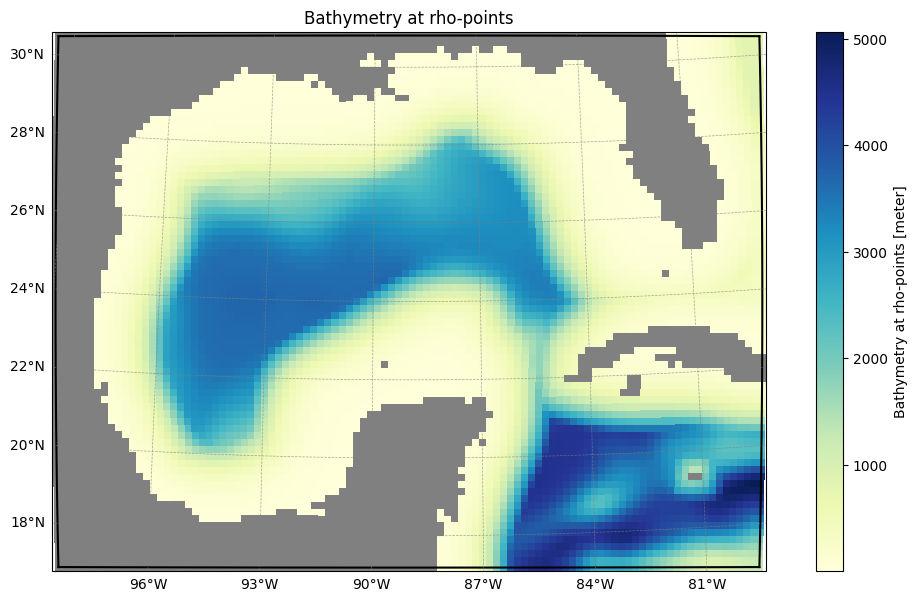

In [7]:
grid.plot()

Once we are happy with our grid, we can save it as a netCDF file via the `.save` method:

In [8]:
grid.save(target_dir / "roms_grd.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_grd.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_grd.nc')]

We can also export the grid parameters to a YAML file. This gives us a more storage-effective way to save and share input data made with `ROMS-Tools`. The YAML file can be used to recreate the same object later.

In [9]:
yaml_filepath = target_dir / "roms_grd.yaml"
grid.to_yaml(yaml_filepath)

You can find more information about creating, plotting, and saving grids [here](https://roms-tools.readthedocs.io/en/latest/grid.html).

### Initial Conditions

In [10]:
from roms_tools import InitialConditions

Here, we want to prepare a simulation in which we run ROMS with MARBL biogeochemistry (BGC), so we need to prepare both physical and BGC initial conditions. We create physical and BGC initial conditions **together** because ROMS needs a **single** initial conditions file. We use

* **GLORYS data** to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities
* a **unified biogeochemical (BGC) climatology** combining multiple observationally and model based sources to create our BGC initial conditions

In [11]:
glorys_path = "/global/cfs/projectdirs/m4746/Datasets/GLORYS/GLOBAL/2012/cmems_mod_glo_phy_my_0.083deg_P1D-m2012-01.nc"
unified_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/UNIFIED/BGCdataset.nc"

In [12]:
%%time
initial_conditions = InitialConditions(
    grid=grid,
    ini_time=start_time,
    source={"name": "GLORYS", "path": glorys_path},
    bgc_source={
        "name": "UNIFIED",
        "path": unified_bgc_path,
        "climatology": True,
    },
    use_dask=True
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-01 00:00:00) within the range [2012-01-01 00:00:00, 2012-01-02 00:00:00]: ['2012-01-01T00:00:00.000000000']
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - 2D horizontal fill is skipped because source data already contains filled values.


CPU times: user 1min 17s, sys: 2.37 s, total: 1min 19s
Wall time: 10.4 s


Here is a plot of the uppermost layer of the temperature field.

[########################################] | 100% Completed | 7.56 sms


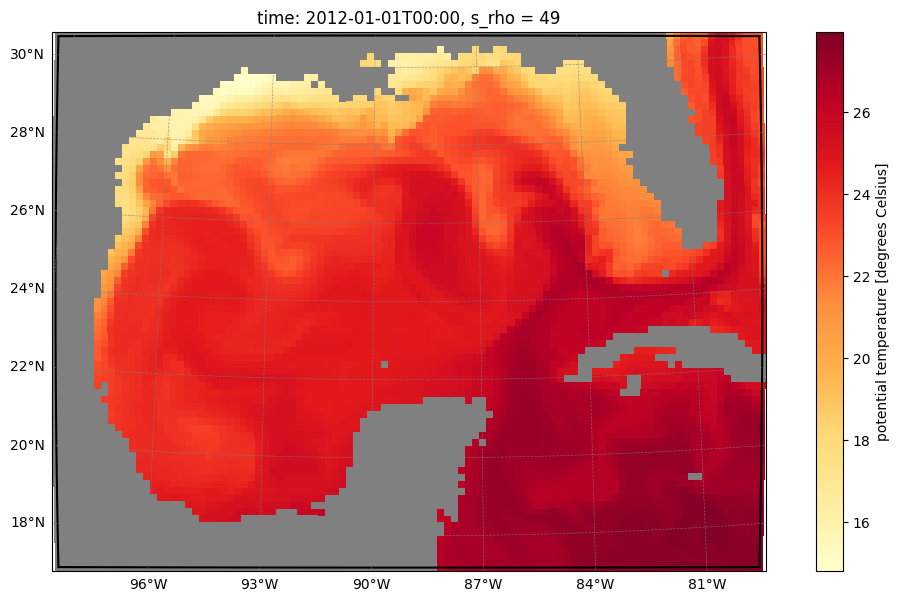

In [13]:
initial_conditions.plot("temp", s=-1)

We can also plot vertical sections of our initial conditions, for example alkalinity.

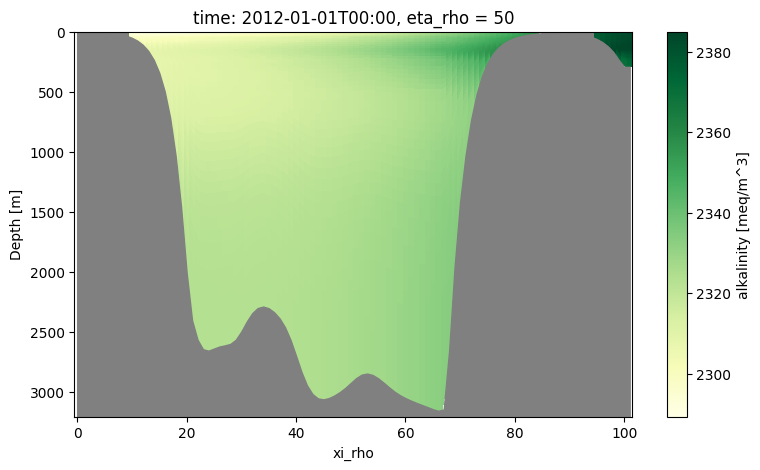

In [14]:
initial_conditions.plot("ALK", eta=50)

We can now save the dataset as a NetCDF and YAML file.

In [15]:
initial_conditions.save(target_dir / "roms_ini.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_ini.nc


[########################################] | 100% Completed | 29.10 ss


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_ini.nc')]

In [16]:
initial_conditions.to_yaml(target_dir / "roms_ini.yaml")

You can find more information about creating, plotting, and saving initial conditions [here](https://roms-tools.readthedocs.io/en/latest/initial_conditions.html).

### Surface Forcing
Next, we create the surface forcing for our domain.

In [17]:
from roms_tools import SurfaceForcing

`ROMS-Tools` can create two types of surface forcing:

* **physical surface forcing** like 10m wind, shortwave radiation, and air temperature at 2m
* **biogeochemical (BGC) surface forcing** like atmospheric pCO2

Unlike initial conditions data, ROMS can read multiple surface forcing files, so we create these two types separately.

#### Physical Surface Forcing

In this subsection, we use ERA5 data to create our physical surface forcing.

In [18]:
%%time
surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5"},
    correct_radiation=True, 
    type="physics",
    use_dask=True
)

INFO - No path specified for ERA5 source; defaulting to ARCO ERA5 dataset on Google Cloud.
INFO - Data will be interpolated onto fine grid.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 3min 37s, sys: 9.66 s, total: 3min 47s
Wall time: 1min 47s


Here is a plot of the zonal wind at the first created time stamp.

[########################################] | 100% Completed | 101.64 ms


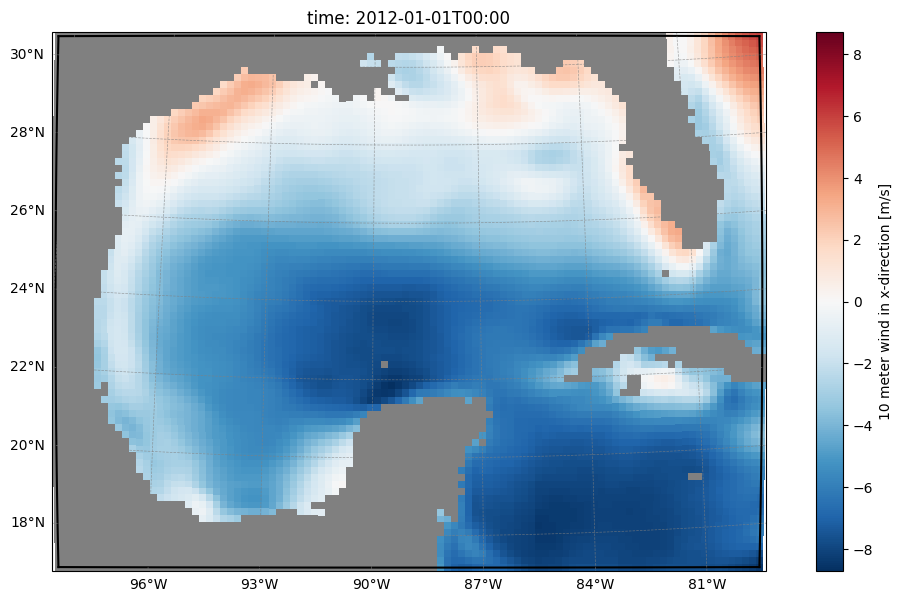

In [19]:
surface_forcing.plot("uwnd", time=0)

Let's save our physical surface forcing to NetCDF and YAML files.

In [20]:
surface_forcing.save(target_dir / "roms_frc.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_frc_201201.nc


[########################################] | 100% Completed | 120.12 s


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_frc_201201.nc')]

In [21]:
surface_forcing.to_yaml(target_dir / "roms_frc.yaml")

#### Biogeochemical (BGC) Surface Forcing
We now create BGC surface forcing. The BGC variables are interpolated from a **unified BGC climatology**, which integrates observationally and model based sources. 

The BGC dataset is located here:

In [22]:
unified_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/UNIFIED/BGCdataset.nc"

In [23]:
%%time

bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
)

INFO - Data will be interpolated onto grid coarsened by factor 2.
INFO - 2D horizontal fill is skipped because source data already contains filled values.


CPU times: user 84.6 ms, sys: 6 μs, total: 84.6 ms
Wall time: 155 ms


We can plot the BGC surface forcing as we saw above.

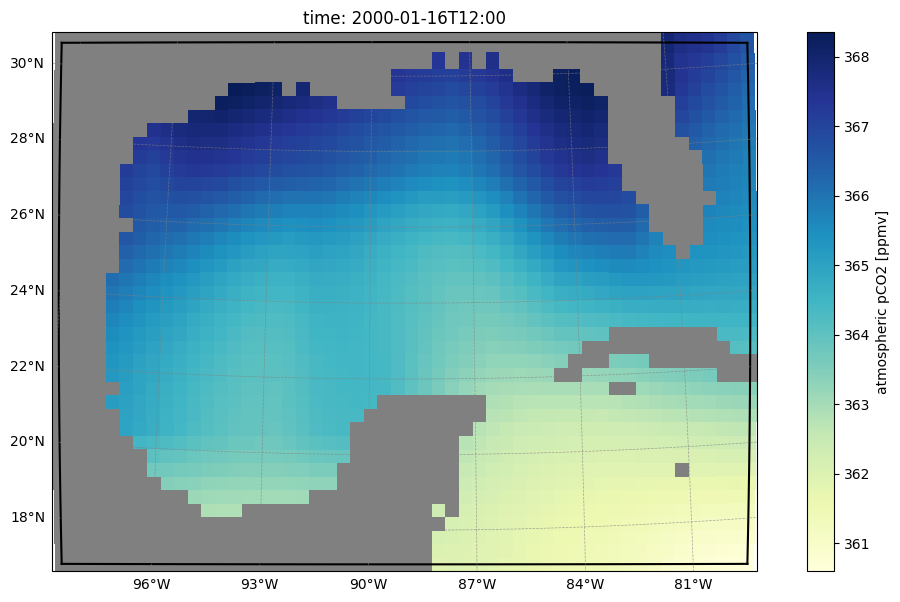

In [24]:
bgc_surface_forcing.plot("pco2_air", time=0)

Finally, we save our BGC surface forcing to NetCDF and YAML files.

In [25]:
bgc_surface_forcing.save(target_dir /"roms_frc_bgc.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_frc_bgc_clim.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_frc_bgc_clim.nc')]

In [26]:
bgc_surface_forcing.to_yaml(target_dir / "roms_frc_bgc.yaml")

You can find more information about creating, plotting, and saving surface forcing [here](https://roms-tools.readthedocs.io/en/latest/surface_forcing.html).

### Boundary Forcing
Next, we create the boundary forcing, or, equivalently, the open boundary conditions.

In [27]:
from roms_tools import BoundaryForcing

`ROMS-Tools` can create two types of boundary forcing:

* **physical boundary forcing** like temperature, salinity, velocities, and sea surface height
* **biogeochemical (BGC) boundary forcing** like alkalinity, dissolved inorganic phosphate, etc.

As with surface forcing, ROMS accepts multiple boundary forcing files, so we create these two types separately.

#### Physical boundary forcing

We use the same GLORYS data as above to create our physical boundary forcing.

In [28]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_path},
    type="physics"
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Applying 1D horizontal fill to southern boundary.
INFO - Applying 1D horizontal fill to eastern boundary.
WARNING - For u, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
WARNING - For v, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
WARNING - For temp, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
WARNING - For zeta, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
INFO - Applying 1D horizontal fill to northern boundary.
INFO - Applying 1D horizontal fill to western boundary.


CPU times: user 11 s, sys: 973 ms, total: 12 s
Wall time: 1min 30s


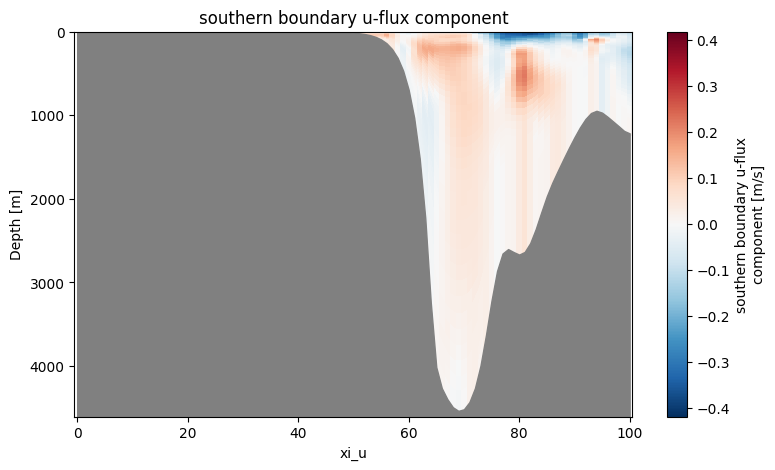

In [29]:
boundary_forcing.plot("u_south", time=0)

In [30]:
boundary_forcing.save(target_dir / "roms_bry.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_bry_201201.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_bry_201201.nc')]

In [31]:
boundary_forcing.to_yaml(target_dir / "roms_bry.yaml")

#### Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from the same unified BGC climatology as above.

In [32]:
%%time

bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc"
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.


CPU times: user 6.44 s, sys: 825 ms, total: 7.26 s
Wall time: 37.8 s


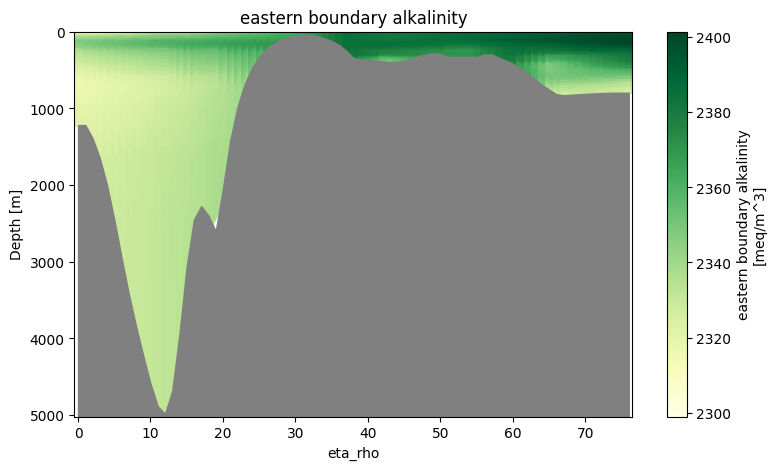

In [33]:
bgc_boundary_forcing.plot("ALK_east", time=0)

In [34]:
bgc_boundary_forcing.save(target_dir / "roms_bry_bgc.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_bry_bgc_clim.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_bry_bgc_clim.nc')]

In [35]:
bgc_boundary_forcing.to_yaml(target_dir / "roms_bry_bgc.yaml")

You can find more information about creating, plotting, and saving boundary forcing [here](https://roms-tools.readthedocs.io/en/latest/boundary_forcing.html).

### River Forcing
Next, we create the river forcing.

In [36]:
from roms_tools import RiverForcing

In [37]:
%time
river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
)

CPU times: user 12 μs, sys: 0 ns, total: 12 μs
Wall time: 21.9 μs


INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
INFO - Compute climatology for river forcing.
INFO - Creating 1 synthetic river(s) to handle overlapping entries.
WARNING - NaN values detected in the 'river_volume' field. These values are being set to zero. This may indicate missing river data, which could affect model accuracy. Consider setting `convert_to_climatology = 'if_any_missing'` to automatically fill missing values with climatological data.


In [38]:
%time
river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
)

CPU times: user 11 μs, sys: 0 ns, total: 11 μs
Wall time: 21.5 μs


INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
INFO - Compute climatology for river forcing.
INFO - Creating 1 synthetic river(s) to handle overlapping entries.
WARNING - NaN values detected in the 'river_volume' field. These values are being set to zero. This may indicate missing river data, which could affect model accuracy. Consider setting `convert_to_climatology = 'if_any_missing'` to automatically fill missing values with climatological data.


WARNING - Only the first 20 rivers will be plotted (received 31).


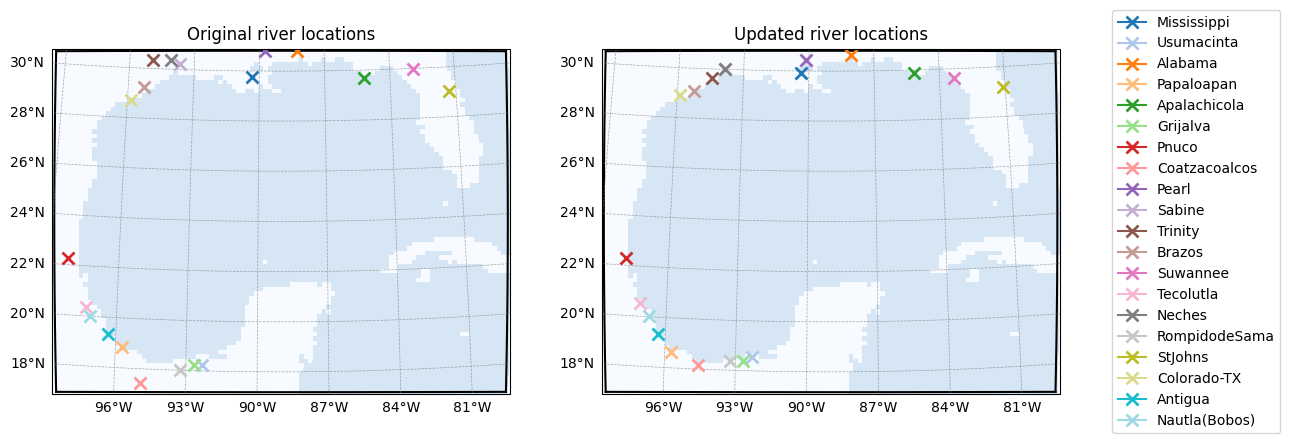

In [39]:
river_forcing.plot_locations()

WARNING - Only the first 20 rivers will be plotted (received 31).


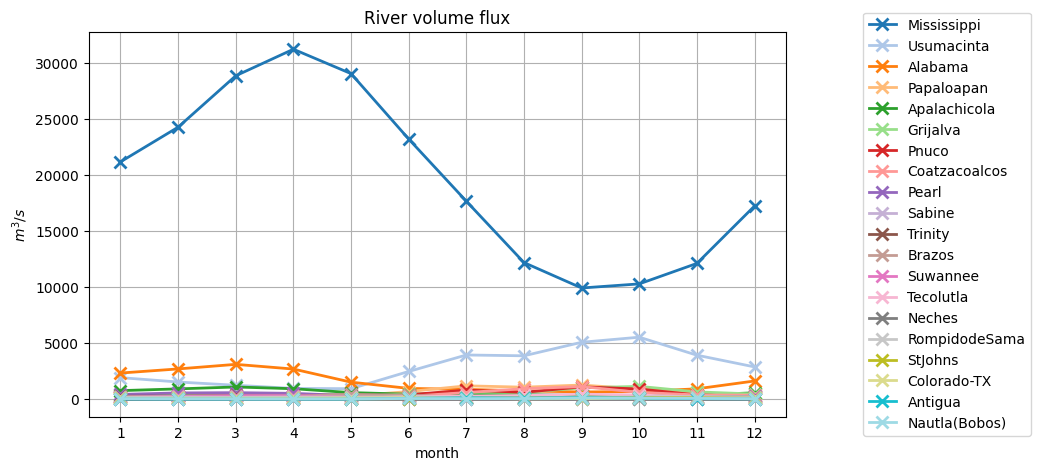

In [40]:
river_forcing.plot("river_volume")

In [41]:
river_forcing.save(target_dir / "roms_rivers.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_rivers.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_rivers.nc')]

In [42]:
river_forcing.to_yaml(target_dir / "roms_rivers.yaml")

### Carbon Dioxide Removal (CDR) Forcing

In [43]:
from roms_tools import TracerPerturbation, CDRForcing

In [44]:
release = TracerPerturbation(
    name="release1",
    lat=28,  # degree N
    lon=-96,  # degree E
    depth=0,  # m
    hsc=100000, # m
    vsc=50,  # m
    tracer_fluxes={"ALK": 2 * 10**6},  # meq/s
)

In [45]:
cdr_forcing = CDRForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    releases=[release]
)

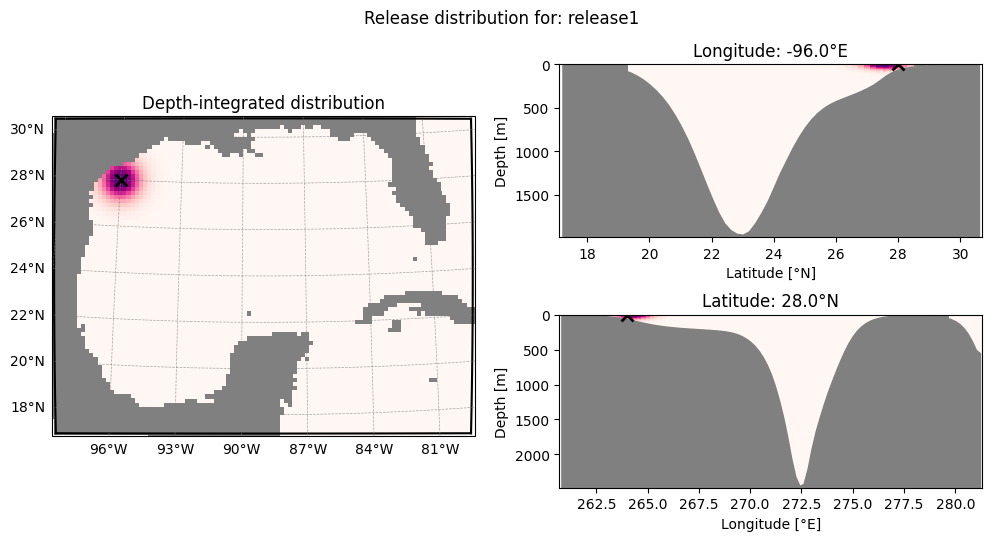

In [46]:
cdr_forcing.plot_distribution(release_name="release1")

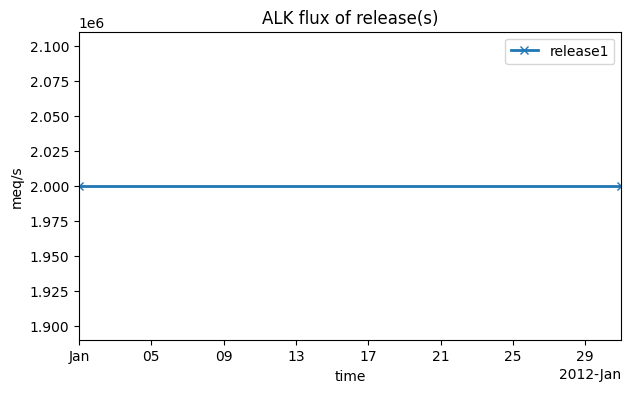

In [47]:
cdr_forcing.plot_tracer_flux(tracer_name="ALK")

In [48]:
cdr_forcing.save(target_dir / "roms_cdr.nc")

INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_cdr.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_cdr.nc')]

In [49]:
cdr_forcing.to_yaml(target_dir / "roms_cdr.yaml")